# imports

In [2]:
import pickle
from srgnn_model import SRGNN_model
from srgnn_datasets import SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

from utils import load_model

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import yaml
from math import ceil
from sklearn.mixture import GaussianMixture
from IPython.display import clear_output

In [3]:
from matplotlib.pyplot import figure

In [4]:
torch.set_float32_matmul_precision('medium')

# data loading

In [4]:
global_run_id='4dm99qnd'

#finetuned_run_id='run-20240302_233004-xh5dmcet'
#global_run_id=finetuned_run_id

In [5]:
model, opt=load_model(global_run_id)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}


In [9]:
with open(f'./GMMs/gmm_val_32_k-means++_{opt.hiddenSize}_{opt.dataset}_{opt.augment_matrix}_{global_run_id}.gmm', 'rb') as gmm_file:
    gm=pickle.load(gmm_file)

In [10]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)
test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 416.35it/s]

done masking


# evaluate each cluster model

## all sessions

In [11]:
session_emb=[]
hit,mrr=[],[]

model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]
    session_emb.append(model.get_session_embeddings(batch).cpu().detach().numpy())

    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score).cpu()
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu())

model.to('cpu')
hit=np.array(hit)
mrr=np.array(mrr)
session_emb=np.concatenate(session_emb)
print('hit ', 100*np.average(hit), 'mrr ', 100*np.average(mrr))

609it [00:20, 29.57it/s]                         


hit  50.688487955568704 mrr  17.722487068651233


In [12]:
session_labels=[]
for i in tqdm(range(ceil(session_emb.shape[0]/opt.batchSize))):
    session_labels.append(gm.predict(session_emb[i*opt.batchSize: (i+1)*opt.batchSize]))
session_labels=np.concatenate(session_labels)

100%|██████████| 609/609 [00:01<00:00, 325.45it/s]


In [ ]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

tsne=TSNE(2)
tsne_session_embeddings=tsne.fit_transform(session_emb)

fig = go.Figure()

for label in np.unique(session_labels):
    label_embedding=tsne_session_embeddings[session_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced session embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/test_sessions_ONVAL_{gm.n_components}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
fig.show()

### trained from scratch

In [28]:
runs_df=pd.read_csv('./wandb_export_raw_all.csv')
runs_df['cluster']=runs_df.Name.map(lambda x: int(x.split('_')[-1]))

In [29]:
cluster_results=[]
cluster_results.append(
{'cluster':-1, 
 'test_loss': np.nan,
 'test_hit': np.average(hit),
 'test_mrr': np.average(mrr)})

for c in tqdm(range(gm.n_components)):
    clear_output(wait=True)
    idxs=np.arange(len(test_data[0]))[session_labels==c]

    cluster_sess=[test_data[0][i] for i in idxs]
    cluster_targets=[test_data[1][i] for i in idxs]
    cluster_data=(cluster_sess,cluster_targets)
    cluster_dataset=SRGNN_Map_Dataset(cluster_data, shuffle=False)
    cluster_dataloader=DataLoader(cluster_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(cluster_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )
    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    
    trainer=pl.Trainer(limit_test_batches=ceil(cluster_dataset.length/opt.batchSize),limit_predict_batches=ceil(cluster_dataset.length/opt.batchSize))
    metrics=trainer.test(cluster_model, cluster_dataloader)[0]#only one dataloader
    metrics['cluster']=c
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    cluster_results.append(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


data masking start
data masking 1
data masking 2
data masking 3
done masking


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │     63.52531051635742     │
│         test_loss         │     5.713991641998291     │
│         test_mrr          │    26.996490478515625     │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 32/32 [01:20<00:00,  2.50s/it]


In [30]:
cluster_results=pd.DataFrame(cluster_results)
cluster_results

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
0,-1,NaN,0.553531,0.248305,NaN,NaN
1,0,6.621505,51.548405,23.252512,53.329782,24.557642
2,1,6.454111,45.515423,18.264372,47.145589,19.081339
3,2,6.628732,40.922070,14.518913,44.805195,16.413542
4,3,6.079962,63.917828,30.493874,64.709763,30.852930
5,4,8.367682,45.151176,20.737585,51.160433,22.815957
6,5,5.501886,68.205498,35.135696,70.256024,34.819782
7,6,6.545033,54.092262,23.490585,57.482599,25.490220
8,7,5.627601,64.603004,26.756392,66.477987,28.742248
9,8,5.816460,60.559658,25.042292,63.295019,26.194494


In [32]:
(cluster_results.test_hit>cluster_results.global_model_hit).any(), (cluster_results.test_mrr>cluster_results.global_model_mrr).any()

(False, True)

In [34]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.test_mrr>cluster_results.global_model_mrr]]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
6,5,5.501886,68.205498,35.135696,70.256024,34.819782


In [36]:
cluster_results.loc[cluster_results.global_model_hit<100*np.average(hit)]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
1,0,6.621505,51.548405,23.252512,53.329782,24.557642
2,1,6.454111,45.515423,18.264372,47.145589,19.081339
3,2,6.628732,40.922070,14.518913,44.805195,16.413542
5,4,8.367682,45.151176,20.737585,51.160433,22.815957
13,12,6.043377,54.361897,22.599600,55.291622,23.257653
16,15,7.424316,36.012962,16.525658,42.018538,19.445396
17,16,9.478106,28.735292,10.815783,35.063694,14.230315
18,17,6.353772,48.304508,22.010084,50.141163,22.443078
21,20,8.149501,38.733315,16.378510,51.173896,22.492508
24,23,12.635973,14.129725,4.684999,21.082391,7.414331


## full sessions

In [124]:
full_session_emb=[]
full_sessions=[]
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    # use only original sessions
    a=batch[3][0]
    a=torch.vstack([torch.zeros(a.shape[1]), a])
    idxs=torch.diff(a, dim=0).sum(axis=1)
    for i in range(len(batch)):
        batch[i]=batch[i][:,idxs>0]
    #print(batch[0].shape)
    #break
    full_sessions.append(batch)
    full_session_emb.append(model.get_session_embeddings(batch).detach().numpy())
full_session_emb=np.concatenate(full_session_emb)

152it [00:13, 11.67it/s]                         


In [125]:
full_session_labels=gm.predict(full_session_emb)

In [126]:
len(full_session_labels)

34034

In [127]:
hit,mrr=[],[]
for batch in tqdm(full_sessions):
    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score)
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1))
hit=np.array(hit)
mrr=np.array(mrr)

100%|██████████| 152/152 [00:12<00:00, 12.41it/s]


In [129]:
full_sess_results=[]
full_sess_results.append(
{'cluster':-1, 
 'global_model_hit': np.average(hit),
 'global_model_mrr': np.average(mrr)})

for c in tqdm(range(gm.n_components)):
    clear_output(wait=True)
    idxs=full_session_labels==c

    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    cluster_model.to('cpu')
    
    chit,cmrr=[],[]
    counter=0
    prev_batch=None
    for batch in (full_sessions):
        batch_idxs=idxs[counter:counter+batch[4].shape[-1]]
        counter+=batch[4].shape[-1]

        batch=[b[:, batch_idxs] for b in batch]
        

        sub_scores, targets=cluster_model.predict_step(batch)
        targets=targets.flatten()
        for score, target in zip(sub_scores, targets):
            correct_pred=torch.isin(target - 1, score)
            chit.append(correct_pred)
            if not correct_pred:
                cmrr.append(0)
            else:
                cmrr.append(1 / (torch.where(score == target - 1)[0][0] + 1))

    metrics={}
    metrics['cluster']=c
    metrics['model_hit']=100*np.average(chit)
    metrics['model_mrr']=100*np.average(cmrr)
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    full_sess_results.append(metrics)

100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


In [131]:
full_sess_results=pd.DataFrame(full_sess_results)

In [136]:
full_sess_results.iloc[(full_sess_results.model_mrr>full_sess_results.global_model_mrr).values]

,cluster,test_loss,test_hit,test_mrr,model_hit,model_mrr,global_model_hit,global_model_mrr
10,9,NaN,NaN,NaN,61.501597,28.099945,62.616822,27.867965
15,14,NaN,NaN,NaN,68.902439,35.281173,68.471954,34.602202


In [135]:
full_sess_results.iloc[(full_sess_results.model_hit>full_sess_results.global_model_hit).values]

,cluster,test_loss,test_hit,test_mrr,model_hit,model_mrr,global_model_hit,global_model_mrr
15,14,NaN,NaN,NaN,68.902439,35.281173,68.471954,34.602202
26,25,NaN,NaN,NaN,63.004172,24.414224,62.054795,24.630326


# finetuned

In [18]:
def get_lenght_distribution(sess_lens, lim=8):
    lens, sizes=np.unique(sess_lens, return_counts=True)
    lim=min(lim, len(lens)-1)
    sizes[lim-1]=np.sum(sizes[lim-1:])
    sizes=sizes[:lim]
    lens=lens[:lim]
    sizes=sizes/sum(sizes)
    return lens, sizes

In [19]:
def get_hit_ratio_per_len(lim=10):
    hit_ratio=[]
    for l in range(1,lim+1):
        if l==lim:
            lidxs=session_len>=l
        else:
            lidxs=session_len==l
        hit_ratio.append(np.average(hit[lidxs]))
    return np.array(hit_ratio)

In [20]:
def consecutive_tokens(sess_tokens):
    prev=set(sess_tokens[0].split(','))
    lens=[]
    for tokens in sess_tokens[1:]:
        curr=set(tokens.split(','))
        lens.append(len(prev&curr))
        prev=curr
    return lens

## all sessions

In [14]:
runs_df=pd.read_csv(f'./csvs/wandb_export_val_diginetica_32_{global_run_id}.csv')
#runs_df=pd.read_csv('./csvs/wandb_export_nonspecial_32.csv')
runs_df['cluster']=runs_df.Name.map(lambda x: int(x.split('_')[-1]))

### evaluate models

In [15]:
def manual_metrics(model, dataloader):
    hit,mrr=[],[]

    model.to('cuda')
    for batch in tqdm(dataloader):
        batch=[b.to('cuda') for b in batch]

        sub_scores, targets=model.predict_step(batch)
        targets=targets.flatten()
        for score, target in zip(sub_scores, targets):
            correct_pred=torch.isin(target - 1, score).cpu()
            hit.append(correct_pred)
            if not correct_pred:
                mrr.append(0)
            else:
                mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu())

    hit=np.array(hit)
    mrr=np.array(mrr)
    return {'cluster_hit': 100*np.average(hit), 'cluster_mrr': 100*np.average(mrr)}, hit, mrr


In [16]:
cluster_results=[]
cluster_results.append(
{'cluster':-1, 
 'cluster_hit': np.average(hit),
 'cluster_mrr': np.average(mrr)})

cluster_hit=np.zeros_like(hit)
cluster_mrr=np.zeros_like(mrr)

for c in trange(gm.n_components):
    clear_output(wait=True)
    if runs_df.loc[runs_df.cluster==c].empty or not (session_labels==c).any():
        continue
    idxs=np.arange(len(test_data[0]))[session_labels==c]

    cluster_sess=[test_data[0][i] for i in idxs]
    cluster_targets=[test_data[1][i] for i in idxs]
    cluster_data=(cluster_sess,cluster_targets)
    cluster_dataset=SRGNN_Map_Dataset(cluster_data, shuffle=False)
    cluster_dataloader=DataLoader(cluster_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(cluster_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )
    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    
    #trainer=pl.Trainer(limit_test_batches=ceil(cluster_dataset.length/opt.batchSize),limit_predict_batches=ceil(cluster_dataset.length/opt.batchSize))
    #metrics=trainer.test(cluster_model, cluster_dataloader)[0]#only one dataloader
    metrics, cluster_hits, cluster_mrrs=manual_metrics(cluster_model, cluster_dataloader)
    cluster_hit[idxs]=cluster_hits
    cluster_mrr[idxs]=cluster_mrrs
    
    metrics['cluster']=c
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    cluster_results.append(metrics)

data masking start


100%|██████████| 64/64 [00:00<00:00, 13993.40it/s]


done masking


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


In [65]:
cluster_results=pd.DataFrame(cluster_results)
cluster_results=cluster_results.merge(pd.DataFrame(np.unique(session_labels, return_counts=True)).T.rename(columns={0:'cluster',1:'cluster_size'}),
                      on='cluster')
cluster_results

,cluster,test_loss,test_hit,test_mrr,cluster_hit,cluster_mrr,global_model_hit,global_model_mrr,size,cluster_size
0,0,NaN,NaN,NaN,40.364676,12.851430,41.580265,13.467263,5594,5594
1,1,NaN,NaN,NaN,54.913728,17.780222,54.763691,17.076665,1333,1333
2,2,NaN,NaN,NaN,57.281553,22.551997,56.957929,21.980069,618,618
3,3,NaN,NaN,NaN,57.422969,17.861377,56.862745,18.362977,714,714
4,4,NaN,NaN,NaN,0.118084,0.028323,47.975709,17.430632,5928,5928
5,5,NaN,NaN,NaN,57.536232,20.947211,57.028986,20.944607,1380,1380
6,6,NaN,NaN,NaN,51.995439,16.012755,52.565564,16.911866,877,877
7,7,NaN,NaN,NaN,47.892720,16.641033,49.042146,17.243173,522,522
8,8,NaN,NaN,NaN,54.166667,17.569401,54.067460,17.221333,1008,1008
9,9,NaN,NaN,NaN,52.140078,20.023029,51.828794,19.636952,1285,1285


In [20]:
(cluster_results.cluster_hit>cluster_results.global_model_hit).any(), (cluster_results.cluster_mrr>cluster_results.global_model_mrr).any()

(True, True)

In [21]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.cluster_mrr>cluster_results.global_model_mrr]]

,cluster,test_loss,test_hit,test_mrr,cluster_hit,cluster_mrr,global_model_hit,global_model_mrr,size
1,1,NaN,NaN,NaN,54.913728,17.780222,54.763691,17.076665,1333
2,2,NaN,NaN,NaN,57.281553,22.551997,56.957929,21.980069,618
5,5,NaN,NaN,NaN,57.536232,20.947211,57.028986,20.944607,1380
8,8,NaN,NaN,NaN,54.166667,17.569401,54.067460,17.221333,1008
9,9,NaN,NaN,NaN,52.140078,20.023029,51.828794,19.636952,1285
10,10,NaN,NaN,NaN,52.254642,18.432093,51.989390,18.080587,1131
11,11,NaN,NaN,NaN,61.975309,19.265392,61.629630,19.146835,2025
14,14,NaN,NaN,NaN,46.882217,15.317109,45.265589,14.588349,433
15,15,NaN,NaN,NaN,54.255903,19.751341,54.420648,19.278753,1821
16,16,NaN,NaN,NaN,42.022941,14.257907,41.188738,13.733987,2877


In [23]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.cluster_hit>cluster_results.global_model_hit]]

,cluster,test_loss,test_hit,test_mrr,cluster_hit,cluster_mrr,global_model_hit,global_model_mrr,size
1,1,NaN,NaN,NaN,54.913728,17.780222,54.763691,17.076665,1333
2,2,NaN,NaN,NaN,57.281553,22.551997,56.957929,21.980069,618
3,3,NaN,NaN,NaN,57.422969,17.861377,56.862745,18.362977,714
5,5,NaN,NaN,NaN,57.536232,20.947211,57.028986,20.944607,1380
8,8,NaN,NaN,NaN,54.166667,17.569401,54.067460,17.221333,1008
9,9,NaN,NaN,NaN,52.140078,20.023029,51.828794,19.636952,1285
10,10,NaN,NaN,NaN,52.254642,18.432093,51.989390,18.080587,1131
11,11,NaN,NaN,NaN,61.975309,19.265392,61.629630,19.146835,2025
14,14,NaN,NaN,NaN,46.882217,15.317109,45.265589,14.588349,433
16,16,NaN,NaN,NaN,42.022941,14.257907,41.188738,13.733987,2877


In [25]:
session_labels.shape

(60858,)

In [24]:
cluster_results.loc[cluster_results.global_model_hit<np.average(hit)*100]

,cluster,test_loss,test_hit,test_mrr,cluster_hit,cluster_mrr,global_model_hit,global_model_mrr,size
0,0,NaN,NaN,NaN,40.364676,12.851430,41.580265,13.467263,5594
4,4,NaN,NaN,NaN,0.118084,0.028323,47.975709,17.430632,5928
7,7,NaN,NaN,NaN,47.892720,16.641033,49.042146,17.243173,522
14,14,NaN,NaN,NaN,46.882217,15.317109,45.265589,14.588349,433
16,16,NaN,NaN,NaN,42.022941,14.257907,41.188738,13.733987,2877
18,18,NaN,NaN,NaN,45.990196,15.470632,47.166667,15.710356,10200
19,19,NaN,NaN,NaN,46.268657,15.958226,46.434494,15.816401,603
21,21,NaN,NaN,NaN,38.778626,13.898352,39.541985,14.174534,655
25,25,NaN,NaN,NaN,47.000000,12.625423,46.200000,12.007298,500
26,26,NaN,NaN,NaN,47.254576,14.100857,45.757072,14.256455,601


In [105]:
df=cluster_results.loc[
    (cluster_results.global_model_hit<np.average(hit)*100)
    #(~cluster_results.cluster.isin([4,31, 18, 0]))
    &(cluster_results.cluster_size<5000)
    ]
df[['cluster', 'cluster_hit', 'global_model_hit',
       'cluster_mrr', 'global_model_mrr',
       'cluster_size']]

,cluster,cluster_hit,global_model_hit,cluster_mrr,global_model_mrr,cluster_size
7,7,47.892720,49.042146,16.641033,17.243173,522
14,14,46.882217,45.265589,15.317109,14.588349,433
16,16,42.022941,41.188738,14.257907,13.733987,2877
19,19,46.268657,46.434494,15.958226,15.816401,603
21,21,38.778626,39.541985,13.898352,14.174534,655
25,25,47.000000,46.200000,12.625423,12.007298,500
26,26,47.254576,45.757072,14.100857,14.256455,601
27,27,37.808642,38.425926,13.187657,12.511661,648


In [127]:
for h,m,s in zip((df.cluster_mrr-df.global_model_mrr).round(2).values, 
                 (df.cluster_hit-df.global_model_hit).round(2).values, 
                 df.cluster_size.values):
    print(h, '&', m, '&', s, '\\\\ \\hline')

-0.6 & -1.15 & 522 \\ \hline
0.73 & 1.62 & 433 \\ \hline
0.52 & 0.83 & 2877 \\ \hline
0.14 & -0.17 & 603 \\ \hline
-0.28 & -0.76 & 655 \\ \hline
0.62 & 0.8 & 500 \\ \hline
-0.16 & 1.5 & 601 \\ \hline
0.68 & -0.62 & 648 \\ \hline


In [126]:
(df.cluster_mrr-df.global_model_mrr).sum()

1.6547073095881437

In [128]:
(df.cluster_size).sum()

6839

### total gain

In [108]:
# drop clusters that did overfit
bad_clusters=df.cluster.values
idxs=(np.logical_and(session_labels!=4, session_labels!=31))
idxs2=False
for i in [session_labels==c for c in bad_clusters]:
    idxs2=np.logical_or(idxs2, i)
idxs=np.logical_and(idxs, idxs2)

In [109]:
np.mean(hit[idxs]), np.mean(cluster_hit[idxs])

(0.42857142857142855, 0.432665594385144)

In [110]:
np.mean(mrr[idxs]), np.mean(cluster_mrr[idxs])

(0.14085584908335996, 0.14387788539086452)

## investigate on sessions types in each cluster

### diginetica

#### calculations

In [29]:
items_df=pd.read_csv('../datasets/diginetica/items.csv').drop(columns='Unnamed: 0')
items_df.head()

,item_id,pricelog2,product.name.tokens,category,item_number,frequency
0,69585,6,"7583,18117,41805,41805,2371",176,7556,45
1,90939,6,"604,18117,41805,41805,2371",176,1245,10
2,69586,0,"2936,18117,41805,41805,2371",176,15895,13
3,30029,7,"4668,41805,41805,56652",176,5037,24
4,7492,9,"3011,4632,10402,9562,9562,11721",684,9655,188


In [115]:
session_df=pd.read_csv('../datasets/diginetica/test_sessions.csv')

In [132]:
test_sessions, test_targets, test_sids=test_data[:3]

In [133]:
session_df.loc[session_df.session_id==289]

,Unnamed: 0,queryId,session_id,userId,timeframe,duration,eventdate,searchstring.tokens,category,items
0,0,292,289,NaN,0,1090,2016-05-26,"67941,2886,53124",0,"126860,791,82380,72561,72562,125013,10240,4204..."
26605,26605,784045,289,NaN,1056294,3380,2016-05-26,NaN,1167,"48222,144377,80620,235,15228,30242,48305,239,1..."


In [123]:
res=[]
session_len=[]
session_frequency=[]
session_price=[]
session_ctokens=[]
session_categories=[]
target_category=[]
session_query=[]

for idx, sid in tqdm(zip(range(len(test_sessions)), test_sids)):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])].sort_values(by='item_number', 
                                                                                          key=np.vectorize(lambda x: test_sessions[idx].index(x)))
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_price.append(np.average(sess_items_df.pricelog2))
    session_ctokens.append(np.average(consecutive_tokens(sess_items_df['product.name.tokens'].values)))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))
    session_query.append(session_df.loc[session])

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_price=np.array(session_price)
session_ctokens=np.array(session_ctokens)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

res.append((-1,
            np.average(session_len),
            np.median(session_len),
            np.average(session_frequency),
            np.median(session_frequency),
            np.average(session_price),
            np.median(session_price),
            np.nanmean(session_ctokens),
            np.nanmedian(session_ctokens),
            np.average(session_categories),
            np.median(session_categories),
            np.average(target_category),
            np.median(target_category)
            ))


for cluster in tqdm(cluster_results.cluster.unique()):
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]

    res.append((cluster,
                np.average(session_len[idxs]),
                np.median(session_len[idxs]),
                np.average(session_frequency[idxs]),
                np.median(session_frequency[idxs]),
                np.average(session_price[idxs]),
                np.median(session_price[idxs]),
                np.nanmean(session_ctokens[idxs]),
                np.nanmedian(session_ctokens[idxs]),
                np.average(session_categories[idxs]),
                np.median(session_categories[idxs]),
                np.average(target_category[idxs]),
                np.median(target_category[idxs])
                ))

  0%|          | 0/60858 [00:00<?, ?it/s]/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|▊         | 5079/60858 [00:06<01:10, 787.70it/s]


KeyboardInterrupt: 

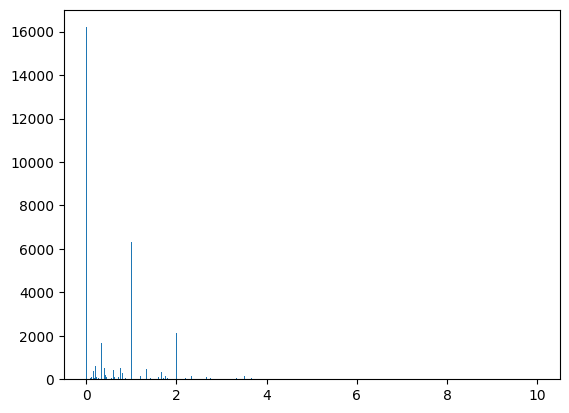

In [ ]:
plt.hist(session_ctokens[~np.isnan(session_ctokens)], bins=1000)
plt.show()

In [ ]:
cluster_results=cluster_results.merge(pd.DataFrame(res, columns=['cluster',
                                             'avg_len', 
                                             'med_len', 
                                             'avg_freq',
                                             'med_freq',
                                             'avg_price',
                                             'med_price',
                                             'avg_ctokens',
                                             'med_ctokens',
                                             'avg_cats',
                                             'med_cats',
                                             'avg_target_cat',
                                             'med_target_cat']), on='cluster').dropna()

#### plots

In [ ]:
max_len=10

##### hit ratio & mrr

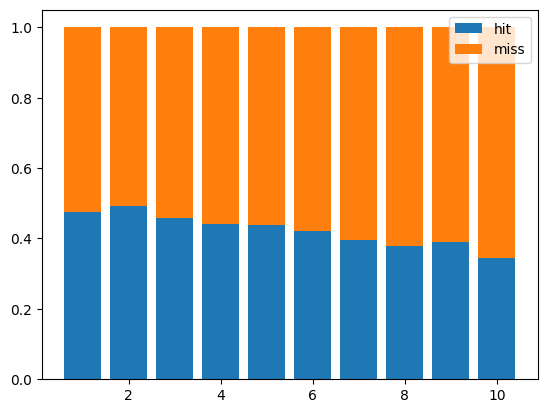

In [ ]:
gl=get_hit_ratio_per_len(lim=max_len)
plt.bar(np.arange(1, max_len+1), gl, label='hit', bottom=0)
plt.bar(np.arange(1, max_len+1), 1-gl, label='miss', bottom=gl)

plt.legend()
plt.show()

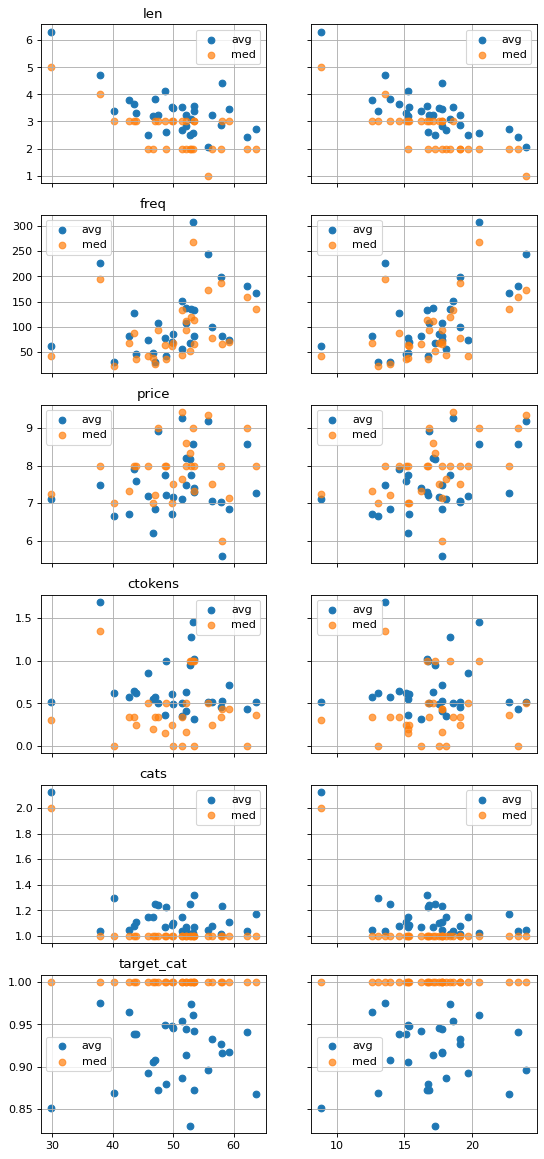

In [ ]:

cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_price',
'med_price',),
('avg_ctokens',
'med_ctokens',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(len(cols), 2, sharex='col', sharey='row', figsize=(8, len(cols)*3), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(cluster_results.test_hit, cluster_results[a], label='avg')
    ax[i,0].scatter(cluster_results.test_hit, cluster_results[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[a], label='avg')
    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


In [ ]:
cluster_results.loc[cluster_results.avg_ctokens>1]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size,avg_len,med_len,avg_freq,med_freq,avg_price,med_price,avg_ctokens,med_ctokens,avg_cats,med_cats,avg_target_cat,med_target_cat
1,1,5.127735,53.372341,20.490824,50.349325,18.954432,2147,2.587797,2.0,308.489087,269.000000,8.564933,9.0,1.453810,1.000000,1.020028,1.0,0.961341,1.0
7,7,5.696970,37.888969,13.545480,35.385612,10.764439,3086,4.729747,4.0,225.733123,195.583333,7.483931,8.0,1.691818,1.345238,1.039533,1.0,0.975049,1.0
10,10,5.296051,53.390450,16.659765,49.577965,14.387389,2251,3.567748,3.0,133.964843,114.000000,7.292574,8.0,1.022567,1.000000,1.320302,1.0,0.872501,1.0
31,31,5.032599,53.027153,18.321112,49.921073,15.942971,2534,3.101815,2.0,135.442651,120.375000,7.750552,8.0,1.283618,1.000000,1.018548,1.0,0.974349,1.0


##### hit&mrr X session length

In [ ]:
clusterXlenXhit=[]
for cluster in cluster_results.cluster.unique():
    idxs=session_labels==cluster
    lenghts=np.unique(session_len[idxs])
    for l in lenghts:
        if l >= max_len:
            l_idxs=np.logical_and(session_labels==cluster, session_len>=l)
            clusterXlenXhit.append((cluster, l, np.average(hit[l_idxs])))
            break
            
        l_idxs=np.logical_and(session_labels==cluster, session_len==l)
        clusterXlenXhit.append((cluster, l, np.average(hit[l_idxs])))

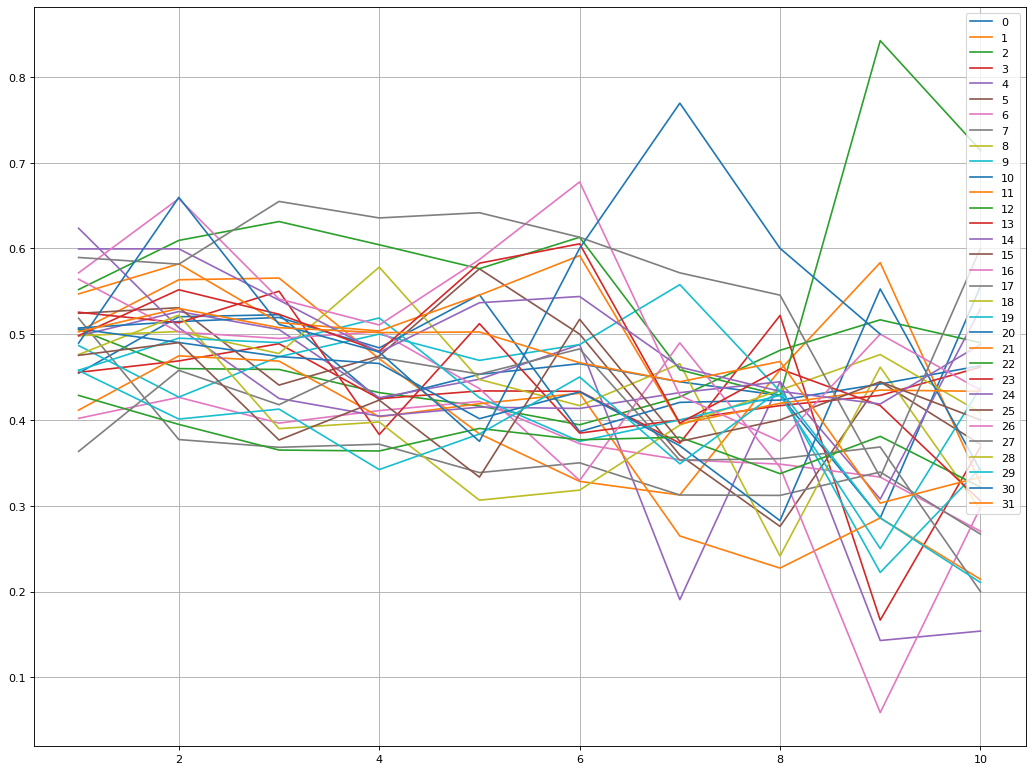

In [ ]:
figure(figsize=(16, 12), dpi=80)

for cluster in cluster_results.cluster.unique():
    plt.plot([x[1] for x in clusterXlenXhit if x[0]==cluster], [x[2] for x in clusterXlenXhit if x[0]==cluster], label=cluster)
plt.legend(loc='upper right')
plt.grid()
plt.show()

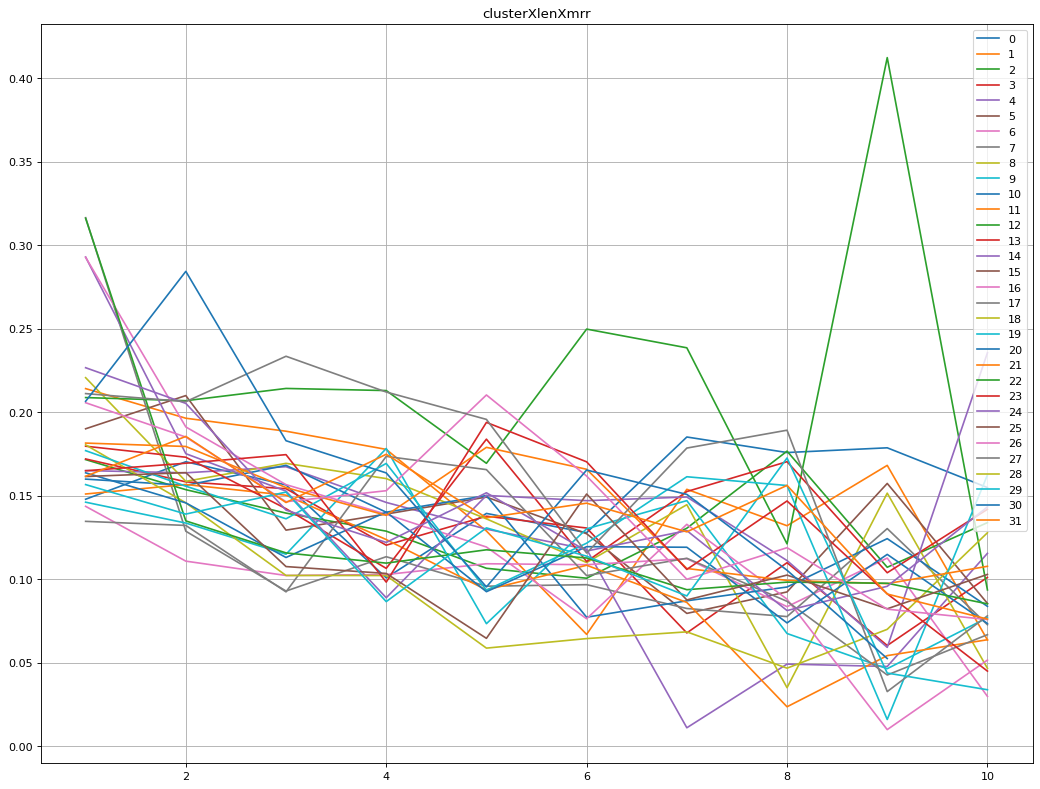

In [ ]:
clusterXlenXmrr=[]
max_len=10
for cluster in cluster_results.cluster.unique():
    idxs=session_labels==cluster
    lenghts=np.unique(session_len[idxs])
    for l in lenghts:
        if l >= max_len:
            l_idxs=np.logical_and(session_labels==cluster, session_len>=l)
            clusterXlenXmrr.append((cluster, l, np.average(mrr[l_idxs])))
            break
            
        l_idxs=np.logical_and(session_labels==cluster, session_len==l)
        clusterXlenXmrr.append((cluster, l, np.average(mrr[l_idxs])))


figure(figsize=(16, 12), dpi=80)

for cluster in cluster_results.cluster.unique():
    plt.plot([x[1] for x in clusterXlenXmrr if x[0]==cluster], [x[2] for x in clusterXlenXmrr if x[0]==cluster], label=cluster)
plt.legend(loc='upper right')
plt.grid()
plt.title('clusterXlenXmrr')
plt.show()

##### length distribution

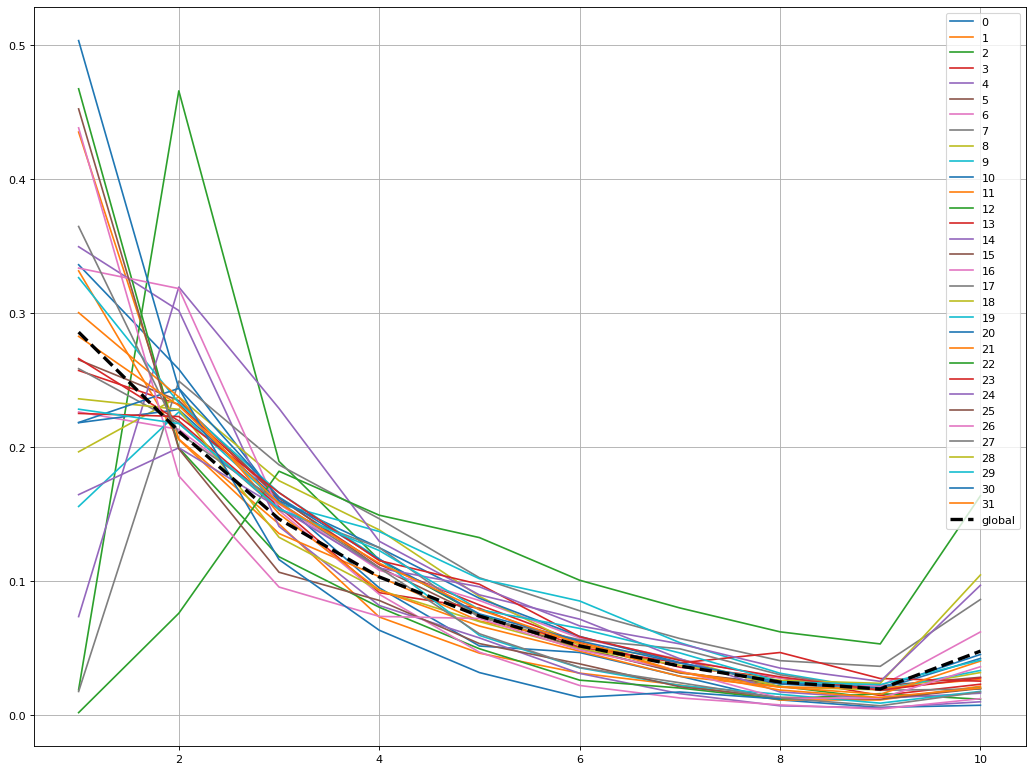

In [ ]:
figure(figsize=(16, 12), dpi=80)
for cluster in cluster_results.cluster.unique():
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]
    clens, csizes=get_lenght_distribution(session_len[idxs], lim=max_len)
    plt.plot(clens, csizes, label=cluster)

clens, csizes=get_lenght_distribution(session_len, lim=max_len)
plt.plot(clens, csizes, label='global', linewidth=3, linestyle='--', color='black')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### yoochoose

#### calculations

In [ ]:
dfs=[]
for k in trange(33003945//int(1e6)):
    df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                     nrows=int(1e6), skiprows=k*int(1e6),
                     names=['session_id','timestamp','item_id','category'])
    df=df[['item_id', 'category']].drop_duplicates()
    dfs.append(df)

items_df=pd.concat(dfs).drop_duplicates()
items_df=items_df.iloc[1:].reset_index(drop=True)
del dfs

100%|██████████| 33/33 [02:36<00:00,  4.74s/it]


In [ ]:
items_df=items_df.merge(pd.DataFrame(pickle.load(
   # open('../datasets/yoochoose_itemdict_nonspecial.txt', 'rb')),
    open('../datasets/yoochoose_itemdict_custom.txt', 'rb')),
                                      index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
             on='item_id')

In [ ]:
#items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]

with open('../datasets/yoochoose_custom/yoo_df.txt', 'rb') as f:
    yoo_df=pickle.load(f)
    freq_df=pd.DataFrame(np.asarray(np.unique(yoo_df.item_id, return_counts=True)).T, columns=['item_id','frequency'])

    items_df=items_df.merge(freq_df, on='item_id')
    del yoo_df
    del freq_df

In [ ]:
test_sessions=[]
test_targets=[]
for batch in test_dataloader:
    sess=batch[2].squeeze().detach()
    for s in sess:
        test_sessions.append(s[s>0].tolist())
   # test_sessions.extend(sess[sess>0].tolist())
    test_targets.extend(batch[4].squeeze().detach().tolist())

In [ ]:
import threading

def get_session_stats(idx, lock):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    l=len(test_sessions[idx])
    cat=sess_items_df.category.nunique()
    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    tcat=any([c in sess_items_df.category.values for c in sess_target_categories])
    clust=session_labels[idx]
    sess_freq=np.average(sess_items_df.frequency)
    with lock:
        session_clusters.append(clust)
        session_len.append(l)
        session_frequency.append(sess_freq)
        session_categories.append(cat)

        target_category.append(tcat)

In [ ]:
session_len=[]
session_frequency=[]
session_categories=[]
session_clusters=[]
target_category=[]

threads=[]
lock=threading.Lock()
try:
    for idx in trange(len(test_sessions)):
        thread=threading.Thread(target=get_session_stats, args=(idx, lock))
        thread.start()
        threads.append(thread)
except KeyboardInterrupt:
    print('User interrupt')
for thread in threads:
    thread.join()


 10%|▉         | 14860/155292 [00:11<01:44, 1337.89it/s]

User interrupt


In [ ]:
session_len=np.array(session_len)
#session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

res=[]
res.append((-1,
            np.average(session_len),
            np.median(session_len),
 #           np.average(session_frequency),
  #          np.median(session_frequency),
            np.average(session_categories),
            np.median(session_categories),
            np.average(target_category),
            np.median(target_category)
            ))


for cluster in tqdm(cluster_results.cluster.unique()):
    idxs=np.arange(session_labels.shape[0])[target_category==cluster]

    res.append((cluster,
                np.average(session_len[idxs]),
                np.median(session_len[idxs]),
    #            np.average(session_frequency[idxs]),
   #             np.median(session_frequency[idxs]),
                np.average(session_categories[idxs]),
                np.median(session_categories[idxs]),
                np.average(target_category[idxs]),
                np.median(target_category[idxs])
                ))

  0%|          | 0/16 [00:00<?, ?it/s]

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 16/16 [00:00<00:00, 370.01it/s]


In [ ]:
res=[]
session_len=[]
session_frequency=[]
session_categories=[]
target_category=[]
for idx in tqdm(range(len(test_sessions))):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

res.append((-1,
            np.average(session_len),
            np.median(session_len),
            np.average(session_frequency),
            np.median(session_frequency),
            np.average(session_categories),
            np.median(session_categories),
            np.average(target_category),
            np.median(target_category)
            ))


for cluster in tqdm(cluster_results.cluster.unique()):
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]

    res.append((cluster,
                np.average(session_len[idxs]),
                np.median(session_len[idxs]),
                np.average(session_frequency[idxs]),
                np.median(session_frequency[idxs]),
                np.average(session_categories[idxs]),
                np.median(session_categories[idxs]),
                np.average(target_category[idxs]),
                np.median(target_category[idxs])
                ))

100%|██████████| 28/28 [00:00<00:00, 1801.90it/s]


In [ ]:
cluster_results=cluster_results.merge(pd.DataFrame(res, columns=['cluster',
                                             'avg_len', 
                                             'med_len', 
                                             'avg_freq',
                                             'med_freq',
                                             'avg_cats',
                                             'med_cats',
                                             'avg_target_cat',
                                             'med_target_cat']), on='cluster').dropna()

In [ ]:
cluster_results

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size,avg_len,med_len,avg_freq,med_freq,avg_cats,med_cats,avg_target_cat,med_target_cat
0,0,5.702363,57.684658,24.344860,58.332007,24.529941,6283,3.530638,2.0,1186.315643,1036.285714,4.237148,4.0,0.971351,1.0
1,2,8.855433,33.317307,20.307404,33.561644,20.231246,1606,5.504359,2.0,288.437606,20.200000,4.132628,3.0,0.936488,1.0
2,3,6.000863,51.506462,22.158379,51.748202,22.107107,14043,3.654846,2.0,844.677716,749.600000,3.916898,3.0,0.964537,1.0
3,4,5.678621,61.543026,25.523424,61.320277,25.756883,5923,3.433902,2.0,1472.998018,1052.666667,4.469019,4.0,0.977714,1.0
4,5,6.129087,55.441578,25.911791,56.426485,26.528630,20540,4.651120,3.0,788.543560,415.900000,4.995910,4.0,0.965433,1.0
5,7,5.614539,60.075893,29.029980,60.299213,29.246889,12700,4.478976,3.0,1364.002453,878.000000,4.840000,4.0,0.972283,1.0
6,8,7.201779,45.021702,20.714191,46.224001,21.708636,15241,5.255167,3.0,381.792273,193.333333,4.903812,4.0,0.955055,1.0
7,9,6.497521,44.738678,16.445778,44.806672,16.437080,3957,3.852161,3.0,351.885673,231.125000,3.272934,2.0,0.973465,1.0
8,11,6.003057,59.184029,27.825968,59.558824,27.912522,3808,3.640756,2.0,684.248031,579.285714,4.570641,4.0,0.971376,1.0
9,12,5.553403,63.086555,27.410488,63.439017,27.025750,3501,3.393031,2.0,1138.135908,978.636364,4.503285,4.0,0.982862,1.0


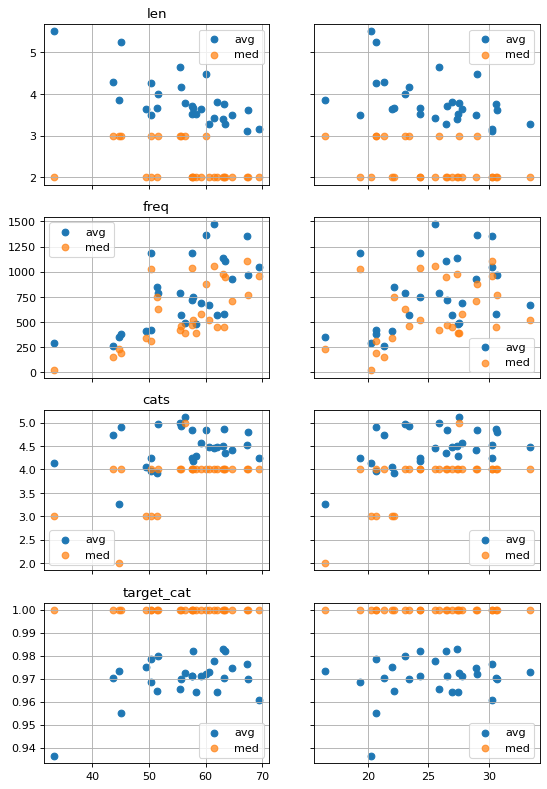

In [ ]:

cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(4, 2, sharex='col', sharey='row', figsize=(8, 12), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(cluster_results.test_hit, cluster_results[a], label='avg')
    ax[i,0].scatter(cluster_results.test_hit, cluster_results[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[a], label='avg')
    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


#### NONSPECIAL


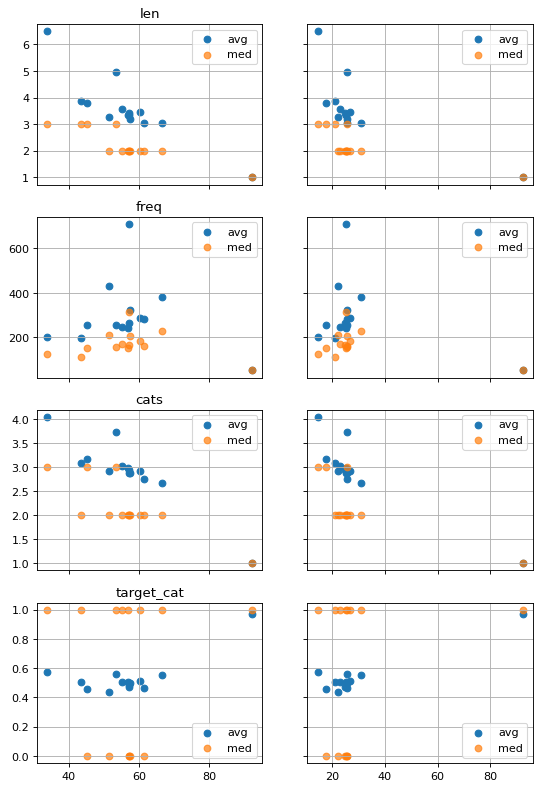

In [ ]:
cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(4, 2, sharex='col', sharey='row', figsize=(8, 12), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(cluster_results.test_hit, cluster_results[a], label='avg')
    ax[i,0].scatter(cluster_results.test_hit, cluster_results[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[a], label='avg')
    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


#### GM&TSNE scatter plot

In [ ]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [ ]:
tsne=TSNE(2)
tsne_session_embeddings=tsne.fit_transform(session_emb)

In [ ]:


fig = go.Figure()

for label in np.unique(session_labels):
    label_embedding=tsne_session_embeddings[session_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced session embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/test_sessions_ontrain_{opt.dataset}_{opt.hiddenSize}.html')
fig.show()

#### 32 clusters, GM trained on test data

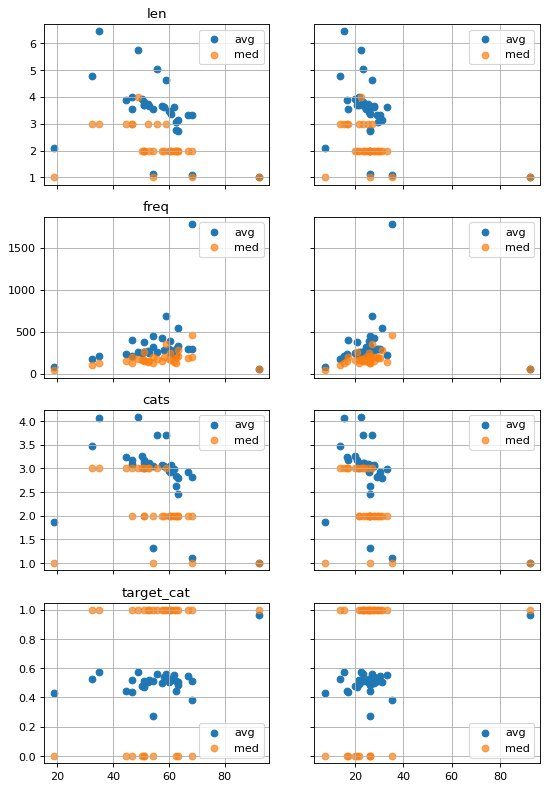

In [ ]:
cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(4, 2, sharex='col', sharey='row', figsize=(8, 12), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(cluster_results.test_hit, cluster_results[a], label='avg')
    ax[i,0].scatter(cluster_results.test_hit, cluster_results[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[a], label='avg')
    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


#### analyse session lengths in a cluster

In [ ]:
clusterXlenXhit=[]
max_len=10
for cluster in cluster_results.cluster.unique():
    idxs=session_labels==cluster
    lenghts=np.unique(session_len[idxs])
    for l in lenghts:
        if l >= max_len:
            l_idxs=np.logical_and(session_labels==cluster, session_len>=l)
            clusterXlenXhit.append((cluster, l, np.average(hit[l_idxs])))
            break
            
        l_idxs=np.logical_and(session_labels==cluster, session_len==l)
        clusterXlenXhit.append((cluster, l, np.average(hit[l_idxs])))

In [ ]:
cluster_results.loc[cluster_results.test_hit<40]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size,avg_len,med_len,avg_freq,med_freq,avg_cats,med_cats,avg_target_cat,med_target_cat
1,2,8.855433,33.317307,20.307404,33.561644,20.231246,1606,5.504359,2.0,288.437606,20.2,4.132628,3.0,0.936488,1.0


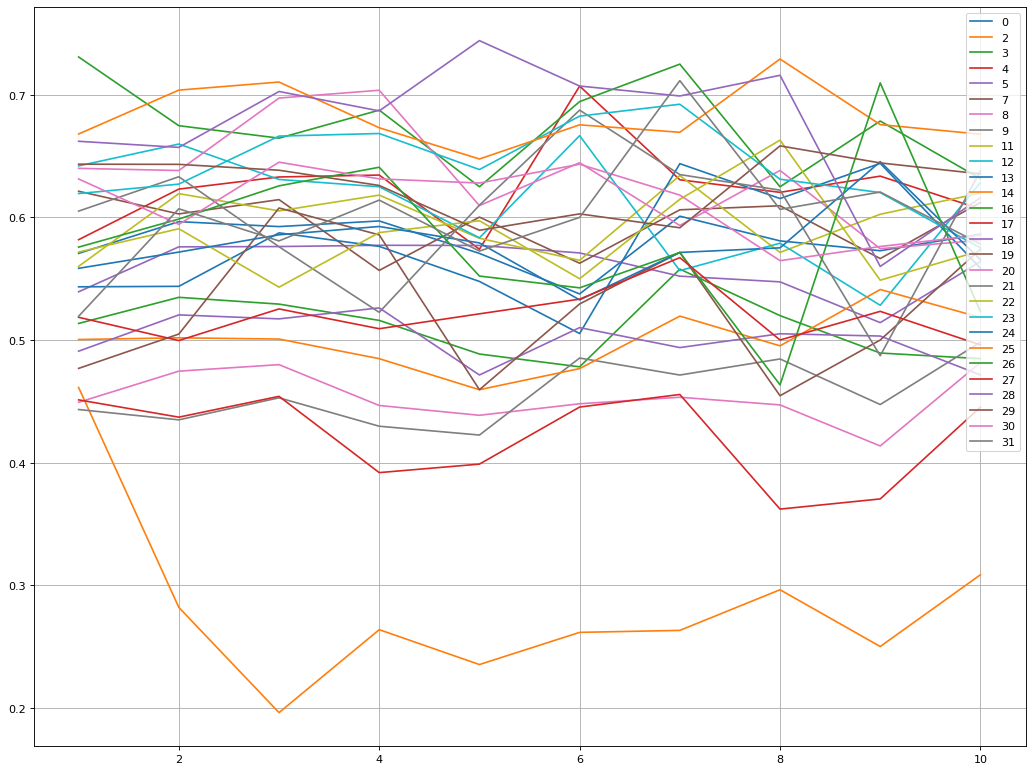

In [ ]:
figure(figsize=(16, 12), dpi=80)

for cluster in cluster_results.cluster.unique():
    plt.plot([x[1] for x in clusterXlenXhit if x[0]==cluster], [x[2] for x in clusterXlenXhit if x[0]==cluster], label=cluster)
plt.legend(loc='upper right')
plt.grid()
plt.show()

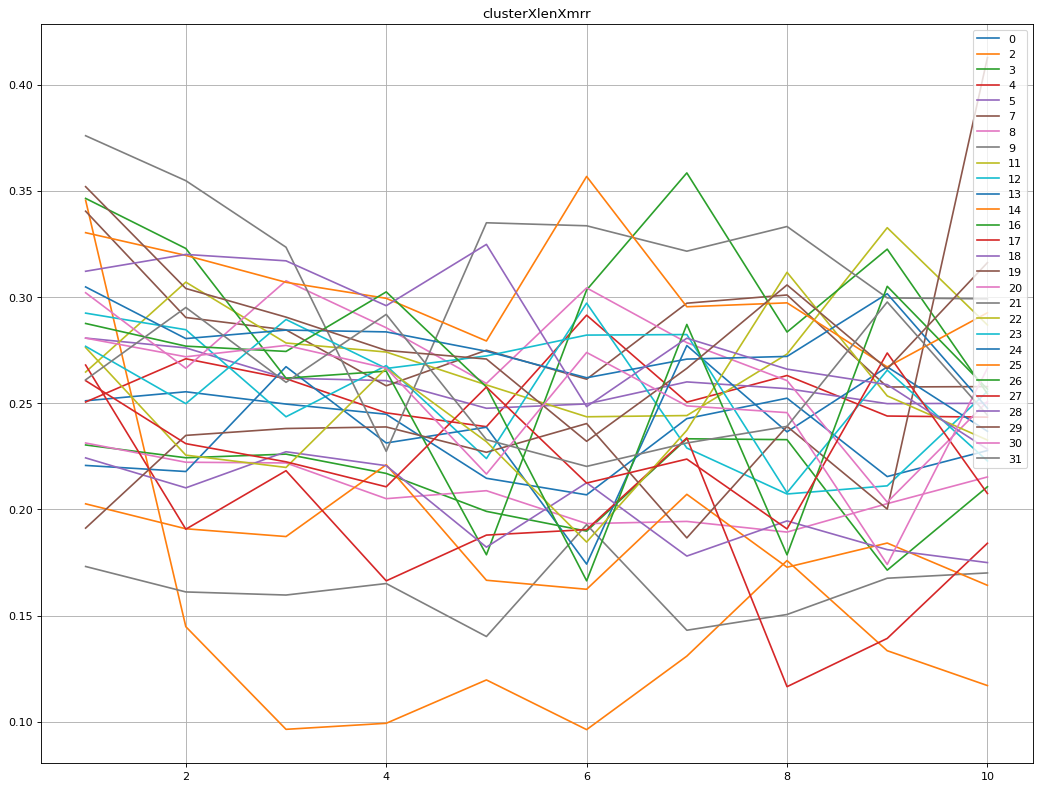

In [ ]:
clusterXlenXmrr=[]
max_len=10
for cluster in cluster_results.cluster.unique():
    idxs=session_labels==cluster
    lenghts=np.unique(session_len[idxs])
    for l in lenghts:
        if l >= max_len:
            l_idxs=np.logical_and(session_labels==cluster, session_len>=l)
            clusterXlenXmrr.append((cluster, l, np.average(mrr[l_idxs])))
            break
            
        l_idxs=np.logical_and(session_labels==cluster, session_len==l)
        clusterXlenXmrr.append((cluster, l, np.average(mrr[l_idxs])))


figure(figsize=(16, 12), dpi=80)

for cluster in cluster_results.cluster.unique():
    plt.plot([x[1] for x in clusterXlenXmrr if x[0]==cluster], [x[2] for x in clusterXlenXmrr if x[0]==cluster], label=cluster)
plt.legend(loc='upper right')
plt.grid()
plt.title('clusterXlenXmrr')
plt.show()

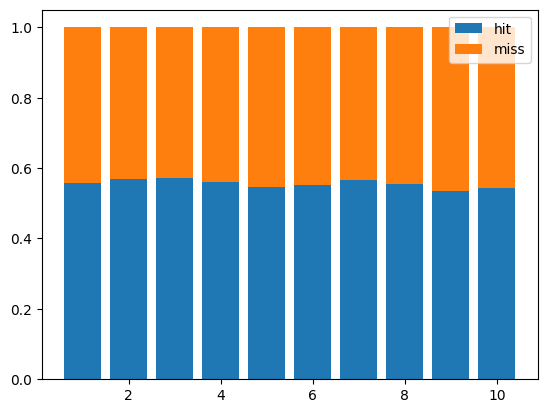

In [ ]:
gl=get_hit_ratio_per_len(lim=max_len)
plt.bar(np.arange(1, max_len+1), gl, label='hit', bottom=0)
plt.bar(np.arange(1, max_len+1), 1-gl, label='miss', bottom=gl)

plt.legend()
plt.show()

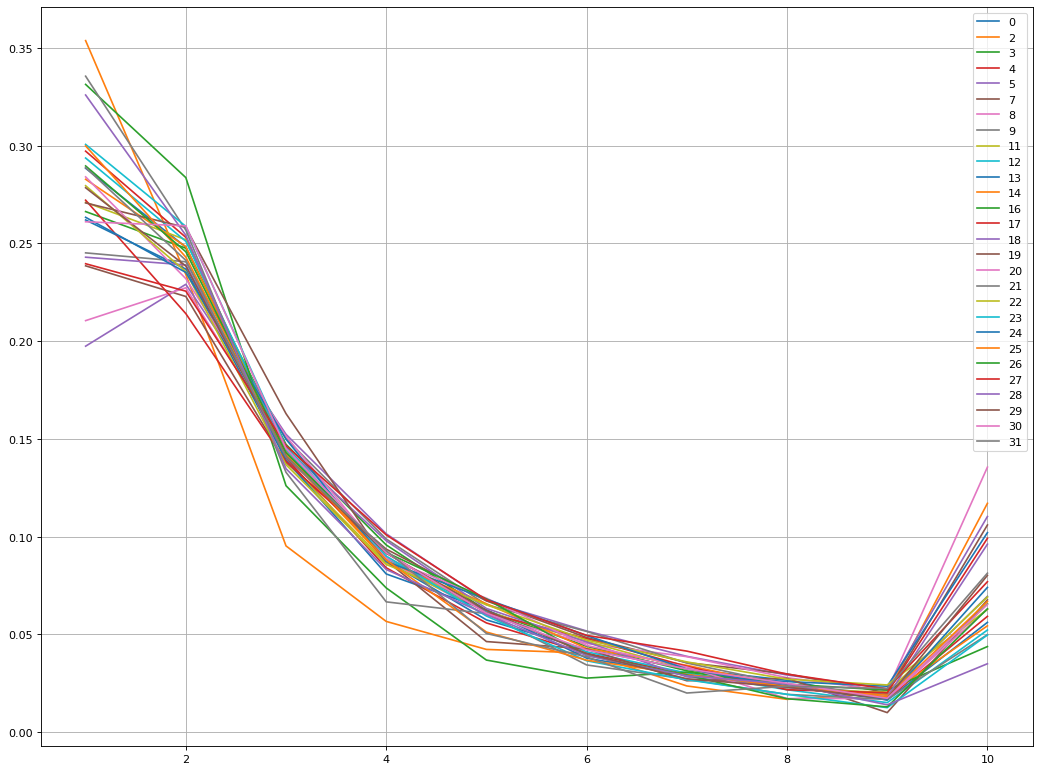

In [ ]:
figure(figsize=(16, 12), dpi=80)
for cluster in cluster_results.cluster.unique():
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]
    clens, csizes=get_lenght_distribution(session_len[idxs], lim=max_len)
    plt.plot(clens, csizes, label=cluster)
plt.legend(loc='upper right')
plt.grid()
plt.show()

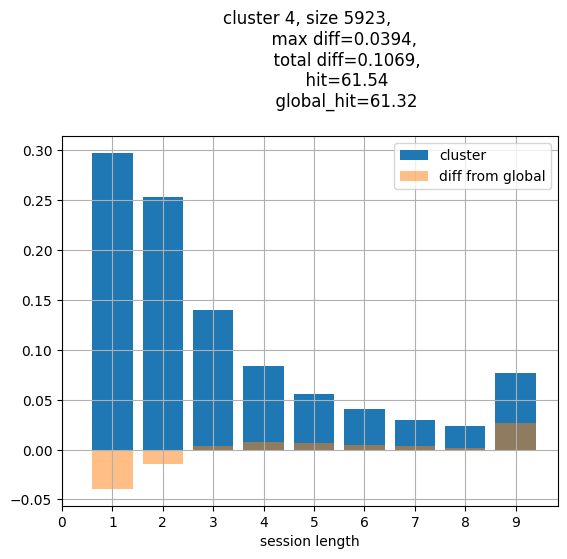

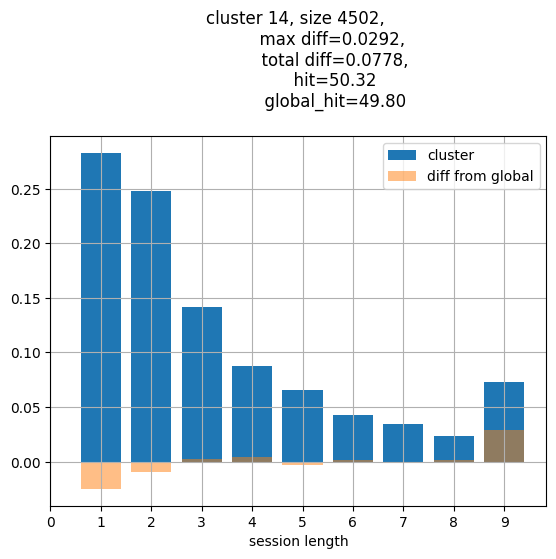

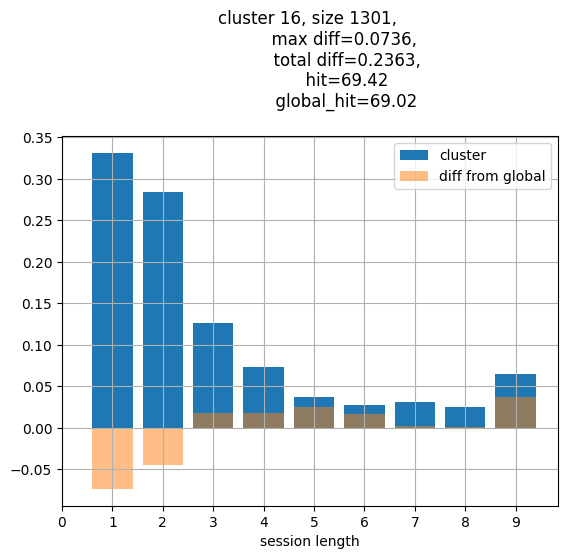

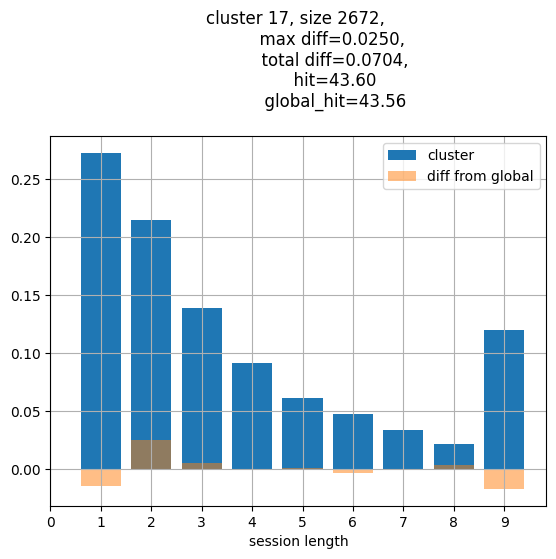

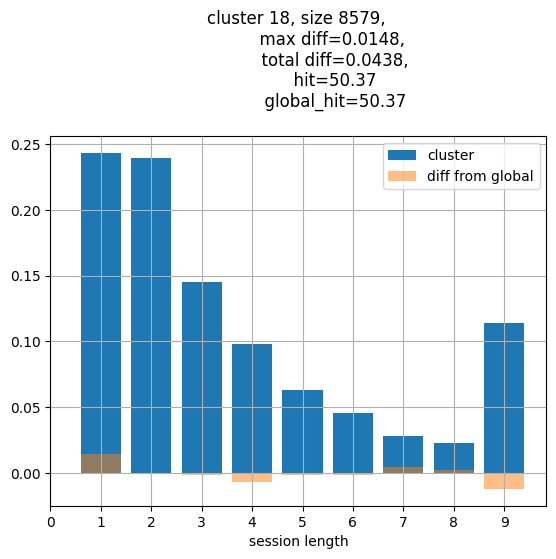

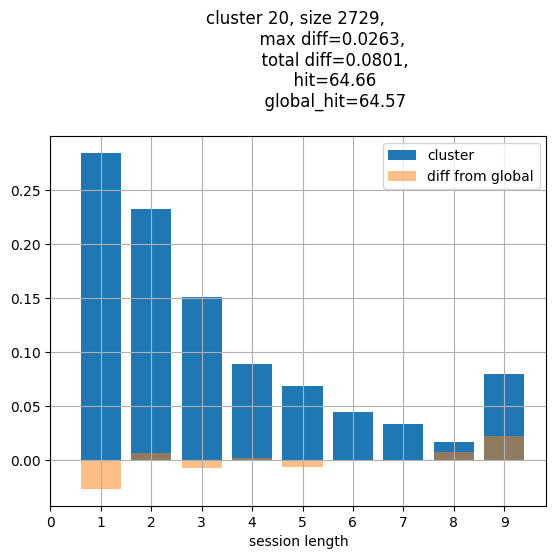

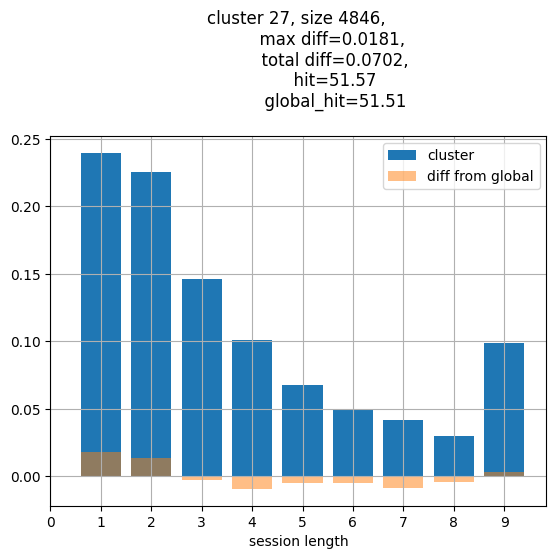

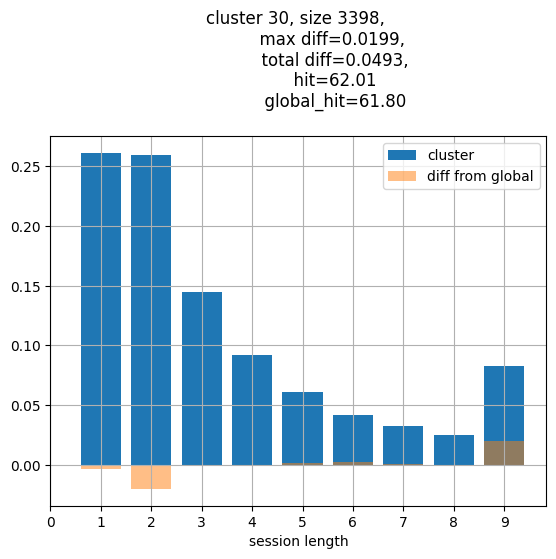

In [ ]:
glens, gsizes=get_lenght_distribution(session_len)

for cluster in cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.test_hit>cluster_results.global_model_hit]].cluster:
#for cluster in cluster_results.cluster.unique():
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]
    clens, csizes=get_lenght_distribution(session_len[idxs])

    plt.bar(clens, csizes, label='cluster')
    plt.bar(clens, gsizes[:len(clens)]-csizes, label='diff from global', alpha=0.5)
    plt.grid()
    plt.xlabel('session length')
    plt.xticks(np.arange(len(clens)+1))
    plt.legend()
    plt.title(f'''cluster {cluster}, size {cluster_results.loc[cluster_results.cluster==cluster]['size'].item()}, 
              max diff={max(np.abs(gsizes[:len(clens)]-csizes)):.4f}, 
              total diff={sum(np.abs(gsizes[:len(clens)]-csizes)):.4f},
              hit={cluster_results.loc[cluster_results.cluster==cluster].test_hit.item():.2f}
              global_hit={cluster_results.loc[cluster_results.cluster==cluster].global_model_hit.item():.2f}
''')
    plt.show()    